# Overhead EBUS-Climate Correlations
Previously, I created an area-weighted time series of CO$_{2}$ flux and Adam Phillip's climate indices. This gives us a picture of how the whole EBUS varies with a climate index predictor. However, it prevents us from getting a taste of the spatial correlations. Perhaps a relatively high correlation score is due to a very high correlated cluster. Perhaps there is a gradient in the correlations themselves. Perhaps there are some negative and some positive scores within a given system.

In [17]:
import glob

# Numerics
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from scipy import signal
import esmtools as et

# Visualization
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
import cmocean
import cartopy.crs as ccrs

# Functions

In [2]:
def detrend_climate(x):
    return signal.detrend(x)

In [3]:
def smooth_series(x, length=12):
    series = pd.rolling_mean(x, length, center=False)
    series = series[(length-1)::]
    return series

In [4]:
def drop_ensemble_dim(ds, x):
    ds[x] = (('nlat','nlon'), ds[x][0])
    return ds

In [5]:
# Constants
ens = ['001', '002', '009', '010', '011',
       '012', '013', '014', '015', '016',
       '017', '018', '019', '020', '021',
       '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031',
       '032', '033', '034', '035', '101',
       '102', '103', '104', '105']

# Visualization

In [ ]:
EBU = 'CalCS'
VAR = 'npgo'

In [43]:
filedir = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/' + EBU.lower() + '/spatial_correlations/'
filepath = (filedir + EBU.lower() + '-unsmoothed-FG_ALT_CO2-' + VAR + '-spatial-correlations.npy')
"""
The results numpy is of size ensemble x lat x lon but is not a netCDF.
(This is how I used to do the correlations, instead of just generating
a DataArray object.) So we have to load in 
"""
results = np.load(filepath)

# Visualization Functions

In [19]:
def setup_map(ax, lon, lat, lat1=np.nan, lat2=np.nan,
              lon1=np.nan, lon2=np.nan):
    if np.isnan(lat1):
        lat1=np.nanmin(lat)
        lat2=np.nanmax(lat)
        lon1=np.nanmin(lon)
        lon2=np.nanmax(lon)
    m = Basemap(projection='eqdc',
                lat_0=(lat1 + lat2)/2,
                lon_0=(lon1 + lon2)/2,
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                resolution='c',
                fix_aspect=False,
                ax=ax)
    m.drawcoastlines()
    #m.drawstates()
    m.drawcountries()
    #m.fillcontinents(color='black')
    m.drawmapboundary(fill_color='white')
    #m.drawparallels(np.arange(np.floor(np.nanmin(lat)), 
    #                          np.ceil(np.nanmax(lat)), 3),
    #               labels=[False,False,False,False], size='x-large',
    #               color='gray')
    #m.drawmeridians(np.arange(np.floor(np.nanmin(lon)), 
    #                          np.ceil(np.nanmax(lon)), 3),
    #               labels=[False, False, False, False], size='x-large',
    #               color='gray')
    return m

In [31]:
def pcolor_it(ax, EBU, data):
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_ALT_CO2/' + EBU + '/filtered_output/'
    ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-FG_ALT_CO2-residuals-chavez-800km.nc')
    lat = ds_residuals['TLAT'].values
    lon = ds_residuals['TLONG'].values
    data = np.ma.array(data, mask=np.isnan(data))    
    lon1,lon2,lat1,lat2 = et.ebus.visual_bounds(EBU)
    m = setup_map(ax, lon, lat, lat1=lat1, lat2=lat2,
                  lon1=lon1, lon2=lon2)
    return m, lon, lat, data, lat2, lon1

In [21]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# Visualization Code

In [29]:
EBU = 'CalCS'
VAR = 'npgo'
fileDir = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/' + EBU.lower() + '/spatial_correlations/'
results = np.load(fileDir + EBU.lower() + '-unsmoothed-FG_ALT_CO2-' + VAR + '-spatial-correlations.npy')

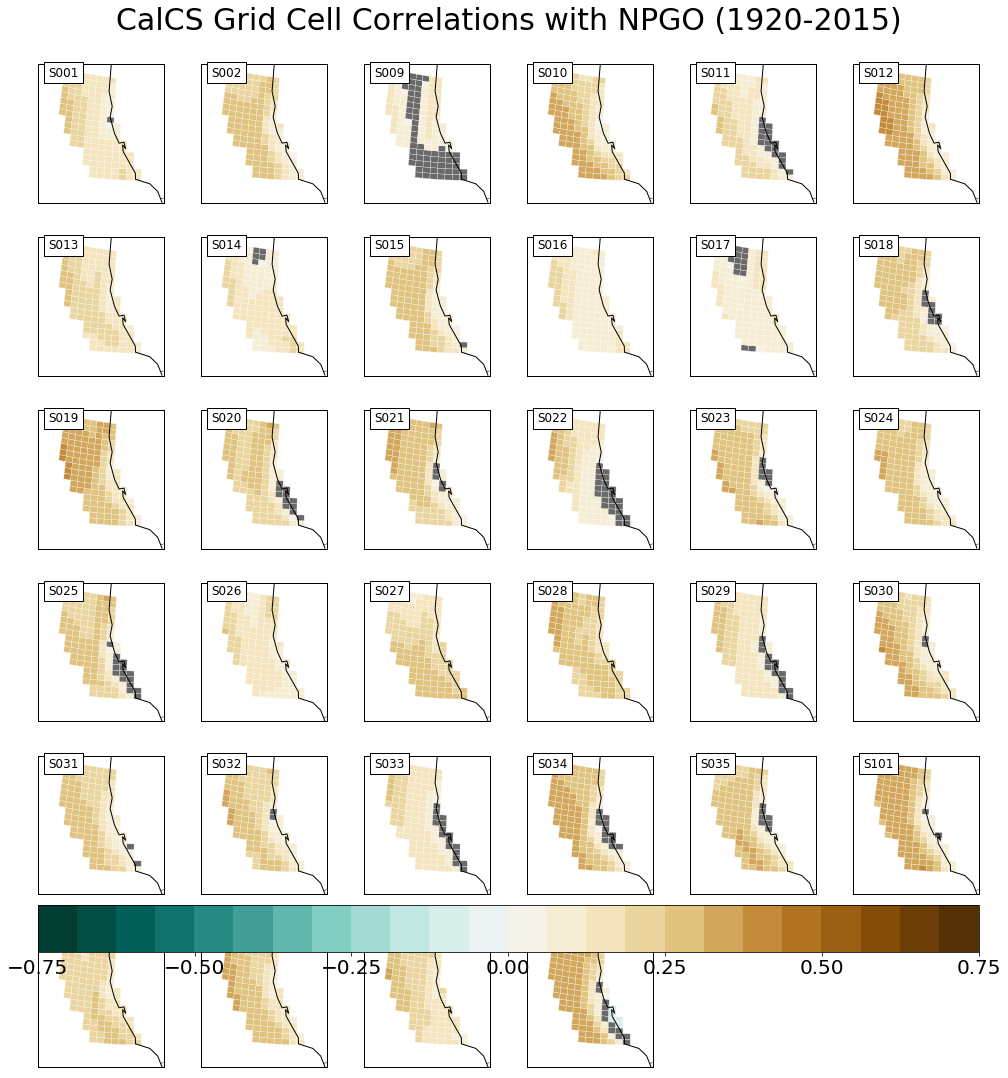

In [35]:
fig,axes = plt.subplots(figsize=(14,16), nrows=6, ncols=6)
st = fig.suptitle(EBU + ' Grid Cell Correlations with ' + VAR.upper() + ' (1920-2015)', fontsize=30)
counter = 0
for ax in axes.flat:
    if counter >= 34:
        fig.delaxes(ax)
    else:
        m, lon, lat, data, lat2, lon1 = pcolor_it(ax, EBU, results[counter])
        x, y = m(lon1, lat2-1.1)
        ax.text(x, y, 'S' + ens[counter], fontsize=12, 
                bbox=dict(facecolor='w', edgecolor='k', alpha=1))
        cs = m.pcolor(lon, lat, data, vmin=-0.75, vmax=0.75 ,
                     latlon=True, cmap=discrete_cmap(24, 'BrBG_r'), edgecolors='w')
        cs.cmap.set_under('#696969')
    counter+=1
fig.tight_layout(pad=3)
cbar = fig.colorbar(cs, location="bottom", aspect=20, ax=axes.ravel().tolist())
cbar.ax.tick_params(labelsize=20, direction='out')
cbar.set_ticks(np.arange(-0.75, 0.76, 0.25))
fig.subplots_adjust(top=0.90)
st.set_y(0.95)
plt.show()